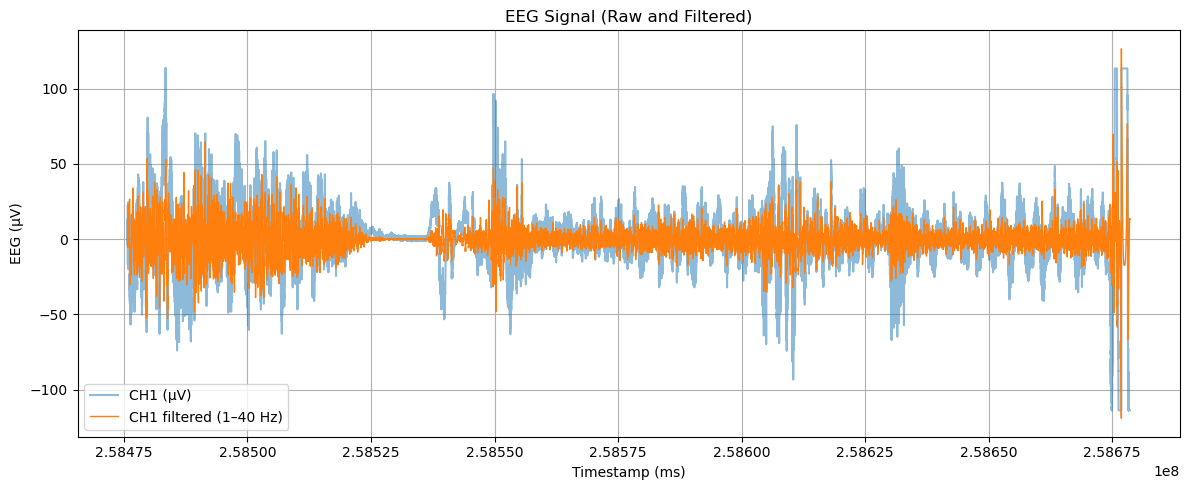

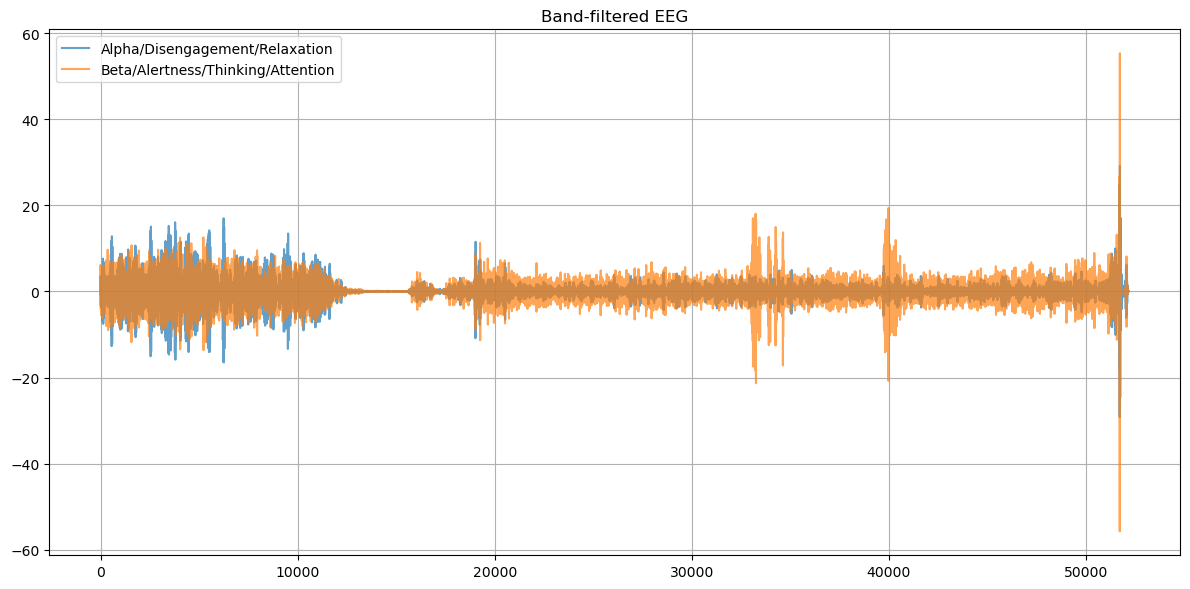

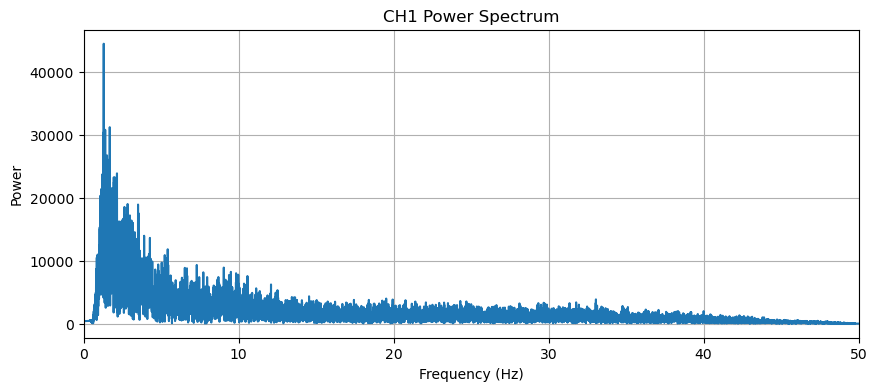

Beta Power: 6.3263897766789485
Alpha Power: 6.639409408339374


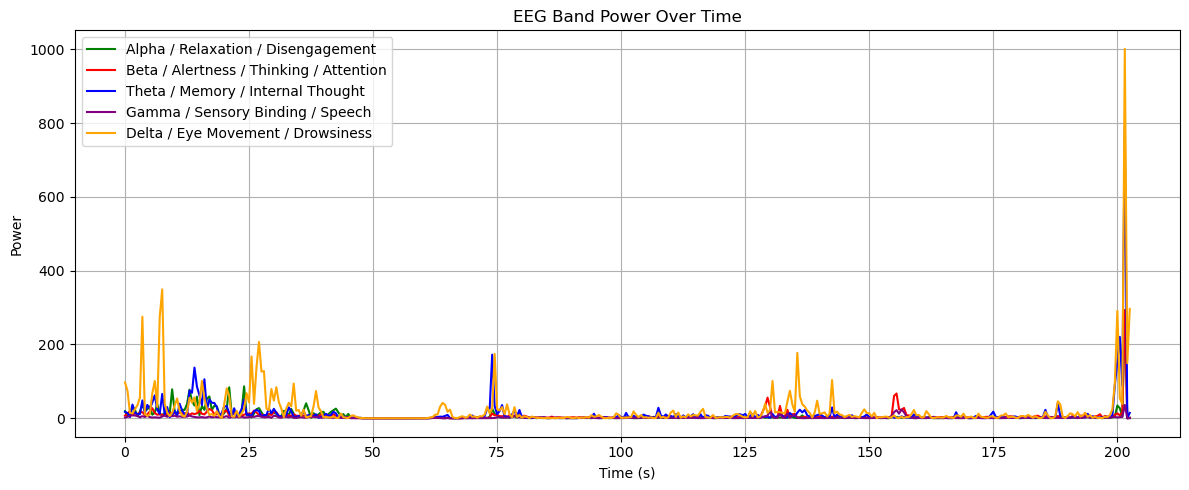

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch
from scipy.fft import rfft, rfftfreq
import numpy as np

# ------------------ Signal Conversion ------------------
def to_microvolts(raw, gain=22000, adc_bits=10, v_ref=5.0):
    offset = 2**(adc_bits - 1)
    volts = (raw - offset) * (v_ref / (2**adc_bits)) / gain
    return volts * 1e6  # convert to µV

# ------------------ Filters ------------------
def notch_filter(data, notch_freq, fs, Q=30):
    b, a = iirnotch(notch_freq, Q, fs)
    return filtfilt(b, a, data)

def bandpass(data, low, high, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, data)

# ------------------ FFT Plot ------------------
def plot_fft(signal, fs, title="FFT"):
    signal = np.asarray(signal)
    N = len(signal)
    yf = np.abs(rfft(signal - np.mean(signal)))
    xf = rfftfreq(N, 1 / fs)
    plt.figure(figsize=(10, 4))
    plt.plot(xf, yf)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.xlim(0, 50)
    plt.grid(True)

# ------------------ Band Power Plot ------------------
def plot_band_power_over_time(signal, fs, band, label, color="blue"):
    window_sec = 1.0
    step_sec = 0.5
    nperseg = int(window_sec * fs)
    step_size = int(step_sec * fs)
    signal = signal.to_numpy()

    powers, times = [], []

    for start in range(0, len(signal) - nperseg, step_size):
        segment = signal[start:start + nperseg]
        freqs, psd = welch(segment, fs, nperseg=nperseg)
        idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
        powers.append(np.trapz(psd[idx_band], freqs[idx_band]))
        times.append(start / fs)

    plt.plot(times, powers, label=label, color=color)
    plt.xlabel("Time (s)")
    plt.ylabel("Power")
    plt.title("EEG Band Power Over Time")
    plt.grid(True)

# ------------------ Load and Preprocess ------------------
df = pd.read_csv("work/eeg_data.csv")
fs = 256  # Hz

# Convert to microvolts
df["ch1_uv"] = to_microvolts(df["ch1"])
df["ch2_uv"] = to_microvolts(df["ch2"])

# Notch filter (50Hz) then bandpass 1–40Hz
df["ch1_clean"] = bandpass(notch_filter(df["ch1_uv"], 50.0, fs), 1, 40, fs)

# Plot raw EEG in µV
plt.figure(figsize=(12, 5))
plt.plot(df["timestamp"], df["ch1_uv"], label="CH1 (µV)", alpha=0.5)
plt.plot(df["timestamp"], df["ch1_clean"], label="CH1 filtered (1–40 Hz)", linewidth=1)
plt.xlabel("Timestamp (ms)")
plt.ylabel("EEG (µV)")
plt.title("EEG Signal (Raw and Filtered)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------ Band Filtering ------------------
df["delta"] = bandpass(df["ch1_uv"], 0.5, 2, fs)
df["theta"] = bandpass(df["ch1_uv"], 4, 7, fs)
df["alpha"] = bandpass(df["ch1_uv"], 8, 12, fs)
df["beta"]  = bandpass(df["ch1_uv"], 13, 30, fs)
df["gamma"] = bandpass(df["ch1_uv"], 30, 50, fs)

# Optional: view band-filtered waveforms
# When listening to something, alpha should go down, beta should go up
plt.figure(figsize=(12, 6))
plt.plot(df["alpha"], label="Alpha/Disengagement/Relaxation", alpha=0.7)
plt.plot(df["beta"], label="Beta/Alertness/Thinking/Attention", alpha=0.7)
#plt.plot(df["delta"], label="Delta/Eye Movement/Drowsiness", alpha=0.7)
#plt.plot(df["theta"], label="Theta/Memory/Internal Thought", alpha=0.7)
#plt.plot(df["gamma"], label="Gamma/Sensory Binding/Speech", alpha=0.7)
plt.legend()
plt.title("Band-filtered EEG")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------ FFT Plot ------------------
plot_fft(df["ch1_clean"], fs, "CH1 Power Spectrum")
plt.show()

# ------------------ Band Power Summary ------------------
def bandpower(signal, fs, band, window_sec=1):
    band = np.asarray(band)
    nperseg = int(window_sec * fs)
    freqs, psd = welch(signal, fs, nperseg=nperseg)
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    return np.trapz(psd[idx_band], freqs[idx_band])

print("Beta Power:", bandpower(df["ch1_clean"], fs, [13, 30]))
print("Alpha Power:", bandpower(df["ch1_clean"], fs, [8, 12]))

# ------------------ Band Power Over Time Plot ------------------
plt.figure(figsize=(12, 5))
plot_band_power_over_time(df["ch1_clean"], fs, [8, 12], "Alpha / Relaxation / Disengagement", "green")
plot_band_power_over_time(df["ch1_clean"], fs, [13, 30], "Beta / Alertness / Thinking / Attention", "red")
plot_band_power_over_time(df["ch1_clean"], fs, [4, 7], "Theta / Memory / Internal Thought", "blue")
plot_band_power_over_time(df["ch1_clean"], fs, [30, 50], "Gamma / Sensory Binding / Speech", "purple")
plot_band_power_over_time(df["ch1_clean"], fs, [0.5, 2], "Delta / Eye Movement / Drowsiness", "orange")
plt.legend()
plt.tight_layout()
plt.show()
